# Libraries

In [ ]:
import pandas as pd
import numpy as np #Used for filtering
from sklearn import preprocessing
import glob, os
import re
import warnings
warnings.filterwarnings("ignore")

# Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# User Defined Utility Functions

In [ ]:
def getFilePath():
  '''Function to get the dynamically fetch the full file path of this notebook for each member in the team NOTE: Takes about a minute'''
  fileName = 'Coursework 2/Deliverables/datacleaning.ipynb' #According to file name of this current notebook

  filePath = glob.glob('/content/drive/**/' + fileName, recursive = True) #A recursive fetch to the notebook

  fullPath = [my_i
  for my_i in filePath if len(my_i) in [max([len(my_i)
  for my_i in filePath])]
  ][0]
  print(fullPath)
  return os.path.dirname(fullPath)


In [ ]:
def bytes_conversion(x):
    if type(x) == float or type(x) == int: return x
    if len(x) > 1:
      if ',' in x: x=x.replace(',', '')
      if 'KB' in x: return float(x.replace('KB', '')) * 1000
      if 'MB' in x: return float(x.replace('MB', '')) * 1000000
      if 'B' in x: return float(x.replace('B', ''))
      return int(re.sub('\D', '', x))

def get_http_resource(query):
  resource = query.split('/')[-1]
  if len(resource) == 0:
    return '-'
  else:
    return query.split('/')[-1]

In [ ]:
def combineDataset(combinedDataFrame, outputFullFilePath):
  '''Combines all the dataset's dataframe into a single dataframe and output as DataExfil.CSV'''
  try:
    print("\nWriting combined dataframe to %s" % outputFullFilePath)
    combinedDataFrame.to_csv(outputFullFilePath, index=False, header=True) #Output to a CSV
    print("Write success")
  except Exception as err:
    print("Write fail")
    print(err)
    return

# Data Cleaning

## Data Filtering

In [ ]:
def data_preprocessing_grp_8(df):
  '''Group 8'''
  print("\nPreprocessing data in Group 8 dataset")
  # processing of NaN value for dest port and bytes in
  df.fillna({'destination.port':0, 'bytes_in':0}, inplace=True)
  # creation and mapping of data-exfil column
  df['src_mac']='-' 
  df['data_exfil'] = 0
  df['data_exfil'] = df['data_exfil'].astype(int)
  df['destination.port'] = df['destination.port'].astype(int)

  result_dict = {"tar.gz": 1, "-": 0,np.nan:0}
  df['data_exfil']=df['dns.question.registered_domain'].map(result_dict)
  df.fillna('-',inplace=True)
  df['type'] = df['type'].str.upper()
  result_dict1 = {"DNS": "UDP", "ICMP":"ICMP"}
  df['network.transport']=df['type'].map(result_dict1)

  #renaming of columns
  df.rename(columns={'query': 'filename','destination.ip': 'src_ip','host.name': 'host_name','destination.port': 'dest_port','network.transport': 'network_transport'}, inplace=True)
  #convert value to bytes
  df['bytes_in'] = df['bytes_in'].apply(bytes_conversion)
  #drop irrelevant columns
  df = df.drop(['@timestamp', 'bytes_out','source.ip','related.ip','dns.question.registered_domain','dns.question.top_level_domain','source.port','status','network.type'], axis=1)
  
  return df

def data_preprocessing_grp_22(df):
  '''Group 22'''
  print("\nPreprocessing data in Group 22 dataset")
  # processing of NaN value for bytes in
  df.fillna({'bytes_in':0}, inplace=True)
  # creation and mapping of data-exfil column
  df['data_exfil'] = 1
  df['bytes_in'] = df['bytes_in'].apply(bytes_conversion)
  df['network.transport'] = df['network.transport'].str.upper()
  df.rename(columns={'destination.ip': 'src_ip','host.name': 'host_name','destination.port': 'dest_port','destination.mac': 'src_mac','network.transport': 'network_transport'}, inplace=True)
  df['filename']='-'
  df['type']='-' 
  df = df.drop(['@timestamp', 'bytes_out','source.ip','source.port','source.mac','network.packets','network.type'], axis=1)

  return df

In [ ]:
def data_preprocessing_grp_5(df):
  '''Group 5'''
  print("\nPreprocessing data in Group 5 dataset")
  #filter non-exfil data
  df['data_exfil'] = 0
  df.loc[(df["destination.ip"] == "172.18.0.3") & (df["source.ip"] == "172.18.0.2"), "data_exfil"] = 1
  #drop irrelevant columns
  df = df.drop(['@timestamp','destination.ip','source.port','network.packets','source.packets','destination.packets','network.bytes', 'destination.bytes', 'event.dataset'], axis=1)
  #renaming of columns
  df.rename(columns={'source.ip': 'src_ip','destination.port': 'dest_port','source.bytes': 'bytes_in'}, inplace=True)
  #creation of columns
  df['host_name'] = "target"
  df['filename'] = '-'
  df['src_mac'] = '-'
  df['network_transport'] = "TCP"
  df['type'] = "SSH"
  df['bytes_in'] = df['bytes_in'].apply(bytes_conversion)
  return df

def data_preprocessing_grp_12(df):
  '''Group 12'''
  print("\nPreprocessing data in Group 12 dataset")
  #drop irrelevant columns
  df = df.drop(['@timestamp','agent.type','destination.bytes','event.type','host.ip','host.os.version','network.packets','source.ip','destination.port','network.type'], axis=1)
  #renaming of columns
  df.rename(columns={'destination.ip': 'src_ip','source.port': 'dest_port','destination.mac': 'src_mac','bytes_out': 'bytes_in','network.transport': 'network_transport','host.name': 'host_name'}, inplace=True)
  #creation of columns
  df['type'] = 'FTP'
  df['network_transport'] = df['network_transport'].str.upper()
  df['filename'] = '-'
  df['data_exfil'] = 1
  df['bytes_in'] = df['bytes_in'].apply(bytes_conversion).astype(int)
  return df


In [ ]:
def data_preprocessing_grp_20(df):
  '''Group 20'''
  print("\nPreprocessing data in Group 20 dataset")
  df = df[['destination.port', 'destination.mac', 'host_name', 'network_transport', 'destination.ip', 'network.type', 'filename', 'bytes_out']]
  df['data_exfil'] = 0

  df.rename(columns={'destination.ip': 'src_ip','destination.port': 'dest_port','destination.mac': 'src_mac','network.type': 'type','bytes_out': 'bytes_in'}, inplace=True)
  df['type'] = df['type'].str.upper()
  df['network_transport'] = df['network_transport'].str.upper()
  df['bytes_in'] = df['bytes_in'].apply(bytes_conversion)
  df['bytes_in'].fillna(0,inplace=True)
  df.loc[(df["dest_port"] == '53') & (df['bytes_in'] != 0), "data_exfil"] = 1
  df["dest_port"] = df["dest_port"].str.replace(',', '')
  df['data_exfil'] = df['data_exfil'].astype(int)
  df["dest_port"] = df["dest_port"].astype(int)
  df['bytes_in'] = df['bytes_in'].astype(int)
  df.drop(df[df['src_ip'] == '-'].index, inplace = True)
  
  return df

def data_preprocessing_grp_21(df):
  '''Group 21'''
  print("\nPreprocessing data in Group 21 dataset")
  df = df.drop(columns=['@timestamp', 'event.original', 'log_type', 'message', 'stream', 'status', 'user', 'action', 'source.ip', 'bytes_in'])
  df['data_exfil'] = 0
  df = df[['destination.port', 'destination.mac', 'host_name', 'network.transport', 'destination.ip', 'network.type', 'filename', 'bytes_out', 'data_exfil']]
  df.rename(columns={'destination.ip': 'src_ip','destination.port': 'dest_port','destination.mac': 'src_mac','network.type': 'type','network.transport': 'network_transport','bytes_out': 'bytes_in'}, inplace=True)
  df['type'] = df['type'].str.upper()
  df['network_transport'] = df['network_transport'].str.upper()
  df.loc[(df["filename"] != '-'), "data_exfil"] = 1
  df['data_exfil'] = df['data_exfil'].astype(int)
  
  return df


In [ ]:
def data_preprocessing_grp_18(df):
  '''Data Cleaning for group 18 dataset cleans apache logs'''
  print("\nPreprocessing data in Group 18 dataset")
  df.index = df.index + 1
  replaceColumnName={'source.address': 'src_ip', "event.outcome":"data_exfil", 'http.response.body.bytes': 'bytes_in', 'host.name':'host_name'}
  df.rename(columns=replaceColumnName,inplace=True)
  df['data_exfil'] = np.where((df['data_exfil'] == 'success'), 1, np.where((df['data_exfil'] == 'failure'), 0, df['data_exfil']))
  df['data_exfil'] = df['data_exfil'].astype(int)
  df['bytes_in'] = df['bytes_in'].str[:-1]
  df['network_transport'] = 'TCP'
  df['type'] = 'HTTP'
  df['dest_port'] = 80 #Server is hosting on port 80
  df['dest_port'] = df['dest_port'].astype(int)
  df['src_mac'] = '02:42:ac:10:00:03' #Obtained information about attacker mac address from team as apache log does not show
  df['filename'] = df['url.path'].str.split('/').str[-1]
  df.insert(df.columns.get_loc("bytes_in") + 1, "bytes_out", 0)
  df['bytes_in'] = df['bytes_in'].astype(int)

  #Columns that will not be features in machine learning
  columnsToDrop = list(df.filter(regex='original')) 
  columnsToDrop = columnsToDrop + list(df.filter(regex='host.os')) 
  columnsToDrop = columnsToDrop + list(df.filter(regex='event')) 
  columnsToDrop = columnsToDrop + list(df.filter(regex='agent')) 
  columnsToDrop = columnsToDrop + list(df.filter(regex='log')) 
  columnsToDrop = columnsToDrop + ['host.mac', 'bytes_out', 'host.ip', 'source.ip', 'service.type', 'http.response.status_code', 'http.request.method', 'url.path', '_id', '_index', 'input.type', 'host.containerized','host.hostname', 'host.id', '_score', 'ecs.version', 'fileset.name', 'host.architecture', 'http.version', 'related.ip', 'nginx.access.remote_ip_list', 'url.extension']
  columnsToDrop.append('@timestamp') #To remove timestamp
  df = df.drop(columnsToDrop, axis=1) #Drops columns in dataset that will not be feature
  return df

#data_preprocessing_grp_18() 

In [ ]:
def data_preprocessing_grp_17(df):
  '''Group 17 dataset'''
  print("\nPreprocessing data in Group 17 Dataset")
  df.index = df.index + 1
  replaceColumnName={'destination.port':'dest_port', "suricata.eve.event_type": "type", "source.ip":"src_ip", "host.name":"host_name", "network.transport":"network_transport"}
  df.rename(columns=replaceColumnName, inplace=True)
  df['filename'] = df['dns.question.subdomain'] + df['dns.question.registered_domain']
  df['bytes_in'] = 0
  df['bytes_in'] = df['bytes_in'].astype(int)
  df['data_exfil']= 1
  df['data_exfil'] = df['data_exfil'].astype(int)
  df['src_mac'] = '02:42:0a:00:00:13' #Asked from the group to provide the attacker MAC
  df['type'] = df['type'].str.upper()
  
  columnsToDrop = list(df.filter(regex='keyword')) 
  columnsToDrop = columnsToDrop + list(df.filter(regex='dns')) 
    
  columnsToDrop = columnsToDrop + list(df.filter(regex='agent')) 
  columnsToDrop.append('@timestamp') #To remove timestamp
  columnsToDrop.extend(('host.mac', 'host.ip', 'destination.ip','source.port', 'event.original', 'event.created', '_index', '_score', '@version', 'suricata.eve.flow_id', 'tags', '_id', 'fileset.name', 'ecs.version', 'log.offset', 'log.file.path', 'event.dataset', 'input.type', 'service.type', 'network.community_id', 'host.os.family', 'host.hostname', 'host.os.codename', 'event.module', 'destination.address', 'host.os.family', 'host.os.codename', 'service.type', 'suricata.eve.in_iface', 'host.architecture', 'host.containerized', 'network.direction', 'host.os.version', 'host.os.type', 'host.os.platform', 'host.id', 'host.os.kernel', 'host.os.name', 'source.address'))
  
  df = df.drop(columnsToDrop, axis=1) #Wont use in dataset
  return df

In [ ]:
# For grp_11 & 10
default_dict = {
    'host.name':np.nan,
    'source.ip':np.nan,
    'source.port':0,
    'source.mac':np.nan,
    'destination.port':0,
    'bytes_in':0,
    'bytes_out':0,
    'type':np.nan,
    'query':np.nan,
    'network.transport':np.nan,
}

# define columns to use
cols = ['host.name','source.ip', 'source.mac','destination.port', 'bytes_in', 
        'type', 'query', 'network.transport']

def data_preprocessing_grp_10(df):
  '''Group 10 dataset'''
  print("\nPreprocessing data in Group 10 Dataset")

  # replace all np.nan with the respective in the default_dict
  df.fillna(default_dict, inplace=True)
  df.rename(columns={'client.ip': 'source.ip'}, inplace=True)

  for col in set(cols).difference(df.columns):
    df.insert(len(df.columns), col, default_dict[col])

  df = df[cols]

  # Rename columns
  df.rename(columns={'host.name': 'host_name','query': 'filename','source.ip': 'src_ip','source.mac': 'src_mac','destination.port': 'dest_port','network.transport': 'network_transport','network.type': 'type'}, inplace=True)

  # Fill NA for X features
  fillna_dict = {
      'host_name':'-',
      'src_ip':'-',
      'src_mac':'-',
      'type':'HTTP',
      'network_transport':'TCP'
  }

  df.fillna(fillna_dict, inplace=True)

  # Further pre-processing
  df['bytes_in'] = df['bytes_in'].apply(bytes_conversion)
  df['filename'] = df['filename'].apply(get_http_resource)

  # Create and tag Y variable
  df['data_exfil'] = 0
  df['data_exfil'] = df['data_exfil'].astype(int)
  df['type'] = df['type'].str.upper()

  # Tagging data-exfil (Y variable) to either 0 or 1 based on dataset
  # see if .sh or some other keywords exist in query then tag data-exfil = 0
  str_ioc = ['credentials', 'limits', 'environ', 'user', 'passwd', 'group', 'log',
            'bash_history', '.ssh', 'hostname', 'group', 'issue', 'gshadow', 
            'shadow', 'confidential', 'important', 'mic', 'secret', 'profile']
  str_ioc_cond = '|'.join(str_ioc) # eg. 'credentials|etc|...'
  df['data_exfil'] = np.where(df['filename'].str.contains(str_ioc_cond), 1, 0)
  return df

def data_preprocessing_grp_11(df):
  '''Group 11 dataset'''
  print("\nPreprocessing data in Group 11 Dataset") 
  # replace all np.nan with the respective in the default_dict
  df.fillna(default_dict, inplace=True)
  # Insert missing cols
  for col in set(cols).difference(df.columns):
    df.insert(len(df.columns), col, default_dict[col])

  df = df[cols] # Keep only columns specified in cols
  df.drop(columns='bytes_in')

  # Rename columns
  df.rename(columns={'host.name': 'host_name','query': 'filename','source.ip': 'src_ip','source.mac': 'src_mac','destination.port': 'dest_port','network.transport': 'network_transport','network.type': 'type','bytes_out': 'bytes_in'}, inplace=True)

  # Fill NA for X features
  fillna_dict = {
      'src_mac':'-',
      'dest_port':0,
  }

  df.fillna(fillna_dict, inplace=True)

  # Further pre-processing
  df['bytes_in'] = df['bytes_in'].apply(bytes_conversion)
  df['filename'] = df['filename'].apply(get_http_resource)
  df['type'] = df['type'].str.upper()
  df['network_transport'] = 'TCP'

  # Creating y/dependant variable
  df['data_exfil'] = 0
  df['data_exfil'] = df['data_exfil'].astype(int)
  return df

## Data Normalization & Reformating + Handling data discrepancy

In [ ]:
def get_dns_filename(filename):
  if ',' in filename:
    filename = filename.split(',')[-1]
  split = filename.split('-')
  filename, extension = split[:-1], split[-1]
  filename = ''.join(filename).strip()
  extension = extension.split('.')[-1]
  return filename

def get_dns_extension(filename):
  if ',' in filename:
    filename = filename.split(',')[-1]
  split = filename.split('-')
  filename, extension = split[:-1], split[-1]
  filename = ''.join(filename).strip()
  extension = extension.split('.')[-1]
  return extension

def get_http_filename(filename):
  filename = re.sub('^([\.]+)', '', filename)
  split = filename.split('.')
  if len(split) <= 1:
    return ''.join(split)
  filename, extension = split[:-1], split[-1]
  filename = ''.join(filename)
  if filename == '':
    filename = '-'
  return filename

def get_http_extension(filename):
  filename = re.sub('^([\.]+)', '', filename)
  split = filename.split('.')
  if len(split) <= 1:
    return '-'
  split = filename.split('.')
  filename, extension = split[:-1], split[-1]
  filename = ''.join(filename)
  if filename == '':
    filename = '-'
  return extension

def get_ftp_filename(filename):
  if '"' in filename:
    filename = filename.replace('"', '')
  if '/./' in filename:
    filename = filename.replace('/./', '')
  elif '/' in filename:
    filename = filename.replace('/', '')
  split = filename.split('.')
  filename, extension = split[:-1], split[-1]
  filename = ''.join(filename)
  if filename == '':
    filename = '-'
  return filename

def get_ftp_extension(filename):
  if '"' in filename:
    filename = filename.replace('"', '')
  if '/./' in filename:
    filename = filename.replace('/./', '')
  elif '/' in filename:
    filename = filename.replace('/', '')
  split = filename.split('.')
  filename, extension = split[:-1], split[-1]
  filename = ''.join(filename)
  if filename == '':
    filename = '-'
  return extension

def get_ip1(ip):
  ip = ip.split('.')
  if len(ip) > 1:
    return ip[0]
  else:
    return '-'

def get_ip2(ip):
  ip = ip.split('.')
  if len(ip) > 1:
    return ip[1]
  else:
    return '-'

def get_ip3(ip):
  ip = ip.split('.')
  if len(ip) > 2:
    return ip[2]
  else:
    return '-'

def get_ip4(ip):
  ip = ip.split('.')
  if len(ip) > 3:
    return ip[3]
  else:
    return '-'

# Hotfix DF cleaning
def hotfix_df_clean(df):
  # Rearrange columns
  arranged_cols = ['host_name', 'src_ip', 'src_mac', 'dest_port', 'type', 
                  'filename', 'network_transport', 'bytes_in', 'data_exfil']
  df = df.reindex(columns=arranged_cols)

  # Splitting filenames to fn and ext
  maskA = df['type'] == 'DNS'
  maskB = df['type'] == 'HTTP'
  maskC = df['type'] == 'FTP'
  df['fn'] = '-'
  df['ext'] = '-'
  df['fn'] = np.where(maskA, df['filename'].apply(get_dns_filename), df['fn'])
  df['ext'] = np.where(maskA, df['filename'].apply(get_dns_extension), df['ext'])

  df['fn'] = np.where(maskB, df['filename'].apply(get_http_filename), df['fn'])
  df['ext'] = np.where(maskB, df['filename'].apply(get_http_extension), df['ext'])

  df['fn'] = np.where(maskC, df['filename'].apply(get_ftp_filename), df['fn'])
  df['ext'] = np.where(maskC, df['filename'].apply(get_ftp_extension), df['ext'])

  # bytes_in for HTTP
  mean_http_exfil_bytes = int(df[(df['type'] == 'HTTP') & (df['data_exfil'] == 1)]['bytes_in'].mean())
  maskA = df['type'] == 'HTTP'
  maskB = df['bytes_in'] <= 0.0
  maskC = df['data_exfil'] == 1
  df['bytes_in'] = np.where(maskA & maskB & maskC, mean_http_exfil_bytes, df['bytes_in'])

  # Clean up where type='IPV4' & dest_port=53 --> type='DNS'
  maskA = df['type'] == 'IPV4'
  maskB = df['dest_port'] == 53
  df['type'] = np.where(maskA & maskB, 'DNS', df['type'])

  # src_ip cleanup - replace all non-ip to '-'
  re_not_ipv4 = '^(?!\d+\.\d+\.\d+\.\d+)'
  maskA = df['src_ip'].str.match(re_not_ipv4)
  df['src_ip'] = np.where(maskA, '-', df['src_ip'])
  # Split ipv4 into 4 columns
  df['src_ip-1'], df['src_ip-2'], df['src_ip-3'], df['src_ip-4'] = '-', '-', '-', '-'
  df['src_ip-1'] = df['src_ip'].apply(get_ip1)
  df['src_ip-2'] = df['src_ip'].apply(get_ip2)
  df['src_ip-3'] = df['src_ip'].apply(get_ip3)
  df['src_ip-4'] = df['src_ip'].apply(get_ip4)

  col_to_drop = ['filename', 'src_ip']
  df = df.drop(col_to_drop, axis=1)
  return df


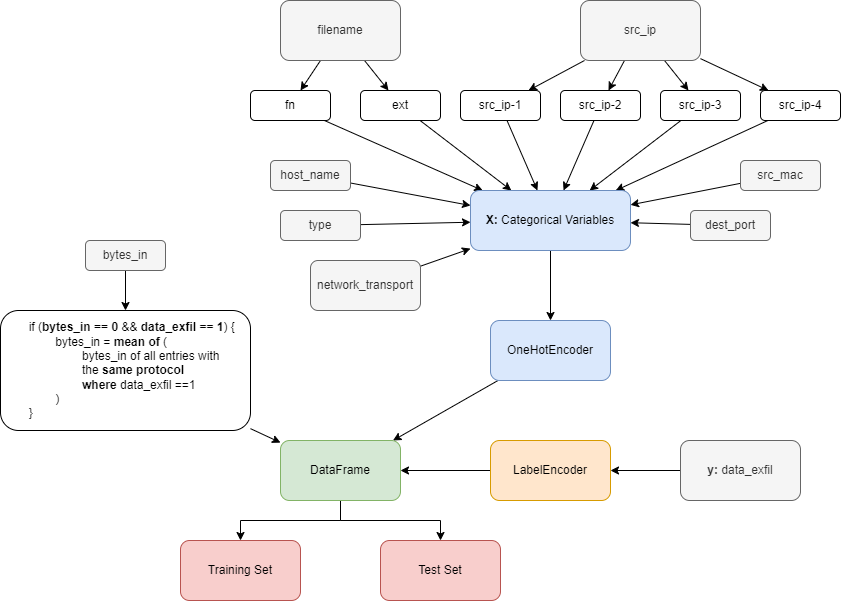

# Main Function

In [ ]:
if __name__ == "__main__":
  
  func_dict = {5: data_preprocessing_grp_5, 
             8: data_preprocessing_grp_8,
             10: data_preprocessing_grp_10,
             11: data_preprocessing_grp_11, 
             12: data_preprocessing_grp_12,
             17: data_preprocessing_grp_17,
             18: data_preprocessing_grp_18,
             20: data_preprocessing_grp_20,
             21: data_preprocessing_grp_21,
             22: data_preprocessing_grp_22}

  ProjectPath = getFilePath()
  cleanDFList = []
  csv_list = glob.glob(ProjectPath + "/datasets/unprocessed/*.csv")
  for csv_file in csv_list: 
    fileid = re.findall(r'\d+',os.path.basename(csv_file))
    if int(fileid[0]) == 8 or int(fileid[0]) == 22: cleanDFList.append(func_dict[int(fileid[0])](pd.read_csv(csv_file, na_values='-')))
    else: cleanDFList.append(func_dict[int(fileid[0])](pd.read_csv(csv_file)))
  
  print("\nCombining dataframes into one")
  combinedDataFrame = pd.concat(cleanDFList, axis=0)
  combinedDataFrame = hotfix_df_clean(combinedDataFrame) # Clean any possible improper data

  combineDataset(combinedDataFrame, ProjectPath + '/datasets/processed/DataExfil.csv')

/content/drive/MyDrive/ICT3204-SA/Coursework 2/Deliverables/datacleaning.ipynb

Preprocessing data in Group 18 dataset

Preprocessing data in Group 17 Dataset

Preprocessing data in Group 11 Dataset

Preprocessing data in Group 10 Dataset

Preprocessing data in Group 12 dataset

Preprocessing data in Group 5 dataset

Preprocessing data in Group 22 dataset

Preprocessing data in Group 8 dataset

Preprocessing data in Group 21 dataset

Preprocessing data in Group 20 dataset

Combining dataframes into one

Writing combined dataframe to /content/drive/MyDrive/ICT3204-SA/Coursework 2/Deliverables/datasets/processed/DataExfil.csv
Write success
